# 8.3. Language – Vision

In this notebook, we will learn how to train a multimodal network. We will explore a language–vision model which matches texts to images. In particular, we implement a simple [CLIP (Contrastive Language-Image Pre-Training)](https://arxiv.org/abs/2103.00020).

CLIP is a neural network trained on various (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similar to the zero-shot capabilities of GPT-2 and 3.

<img src="https://github.com/openai/CLIP/raw/main/CLIP.png">


## 0. Preparation

In order to run this notebook, we need to perform some preparations.

### Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [os](https://docs.python.org/3/library/os.html) provides a portable way of using operating system-dependent functionality, e.g., modifying files/folders.
 * [pandas](https://pandas.pydata.org/) provides easy working routines with tabular data structures.
 * [argparse](https://docs.python.org/3/library/argparse.html) is a module making it easy to write user-friendly command-line interfaces.
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.
 * [transformers](https://github.com/huggingface/transformers) provides pretrained models to perform tasks on different modalities such as text, vision, and audio.

In [1]:
import numpy as np
import os
import pandas as pd
import argparse
import itertools

import matplotlib.pyplot as plt
from PIL import Image as pil_image

import torch
from torch import nn
import torchvision

from transformers import DistilBertModel, DistilBertTokenizer

### device
Choosing CPU or GPU based on the availability of the hardware.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### arguments

We use the `argparse` module to define a set of parameters that we use throughout this notebook:
* The `argparse` is particularly useful when writing Python scripts, allowing you to run the same script with different parameters (e.g., for doing different experiments).
* In notebooks using `argparse` is not necessarily beneficial, we could have hard-coded those values directly in variables, but here we use `argparse` for learning purposes.

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--epochs", type=int, default=5, help="number of training epochs")
parser.add_argument("--batch_size", type=int, default=8, help="size of the batches")
parser.add_argument("--num_workers", type=int, default=0, help="num_workers")

parser.add_argument("--head_lr", type=float, default=1e-3, help="")
parser.add_argument("--image_encoder_lr", type=float, default=1e-4, help="")
parser.add_argument("--text_encoder_lr", type=float, default=1e-5, help="")
parser.add_argument("--weight_decay", type=float, default=1e-3, help="")
parser.add_argument("--projection_dim", type=float, default=256, help="")

parser.add_argument("--model_vision", type=str, default='resnet50', help="")
parser.add_argument("--model_text", type=str, default='distilbert-base-uncased', help="")

parser.add_argument("--img_size", type=int, default=224, help="size of each image dimension")
parser.add_argument("--sample_interval", type=int, default=500, help="interval between image sampling")
parser.add_argument("--out_dir", type=str, default="./out/clip_out/", help="the output directory")
parser.add_argument("--data_dir", type=str, default="./data/", help="the dataset directory")

def set_args(*args):
    # we can pass arguments to the parse_args function to change the default values. 
    opt = parser.parse_args([*args])
    # creating the output directory
    os.makedirs(opt.out_dir, exist_ok=True)
    return opt

## 1. Datasets

We have created the [TinyFlicker](https://www.dropbox.com/s/zi46giyvvch0k8q/TinyFlicker.tar.gz?dl=0) dataset 
which is a subset of [Flickr8k](http://hockenmaier.cs.illinois.edu/8k-pictures.html) dataset.
The *TinyFlicker* contains:
* 1000 images,
* 5 captions per image.

### Download and extract

The `download_and_extract_db` function downloads and extracts the dataset if it's not already
stored in the provided directory. We use two functions already implemented in `torchvision.datasets.utils`:
* `download_url`
* `extract_archive`

In [4]:
def download_and_extract_db(data_dir):
    db_url = "https://dl.dropboxusercontent.com/s/zi46giyvvch0k8q/TinyFlicker.tar.gz"
    torchvision.datasets.utils.download_url(db_url, data_dir)

    data_dir = torchvision.datasets.utils.extract_archive(
        "%s/TinyFlicker.tar.gz" % data_dir, "%s/TinyFlicker/" % data_dir
    )
    return data_dir

### Text Tokeniser

We could have created our own text tokeniser similar to the [text classification notebook](text_classification.ipynb).
But in this tutorial, we use `DistilBertTokenizer` from the `transformers` package.

In [5]:
text_tokeniser = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

### Dataset class

The `TinyFlicker` class reads the dataset file and returns the pair of image-caption.

In [6]:
class TinyFlicker(torch.utils.data.Dataset):
    def __init__(self, root, data_frame, tokeniser, transforms=None, max_tokens=50):
        self.root = root
        self.captions = data_frame['caption'].values
        self.images = data_frame['image'].values
        self.tokeniser = tokeniser
        self.transforms = transforms
        self.max_tokens = max_tokens

    def __getitem__(self, idx):
        # loading the image
        img = pil_image.open("%s/imgs/%s" % (self.root, self.images[idx]))
        # performing the transformation functions
        if self.transforms:
            img = self.transforms(img)
        caption = self.captions[idx]

        # tokenising the text
        tout = self.tokeniser(caption, truncation=True, max_length=self.max_tokens)
        input_ids = torch.tensor(tout['input_ids'])
        attention_mask = torch.tensor(tout['attention_mask'])
        # all elements in each batch should have the same length, therefore we pad
        # the tensors into an identical length
        input_ids = nn.functional.pad(input_ids, (0, self.max_tokens - len(input_ids)), value=0)
        attention_mask = nn.functional.pad(attention_mask, (0, self.max_tokens - len(attention_mask)), value=0)

        item = {
            'image': img,
            'caption': caption,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }
        return item

    def __len__(self):
        return len(self.captions)

### Transform functions

In this tutorial, we use the same set of transform functions for training and testing. 
Essentially, we only resize the input images and convert them to a normalised tensor.
One could add data augmentation to the training images such as random cropping or 
horizontal flipping. We leave this as an exercise for interested readers.

In [7]:
def get_transforms(target_size, for_network=True):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    transform_funs = [
        torchvision.transforms.Resize(target_size),
        torchvision.transforms.CenterCrop(target_size)
    ]
    # if for_networks is False we don't convert it to Tensor and normalisation. This
    # makes it easier for visualisation purposes.
    if for_network:
        transform_funs.extend([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std)
        ])
    return torchvision.transforms.Compose(transform_funs)

### Sample items

Let's create an instance of our dataset and explore its content. The first time you execute the 
the following cell, it downloads the dataset and extracts its content in the `data_dir` directory.

In [8]:
data_dir = './data/'
data_dir = download_and_extract_db(data_dir)
data_frame = pd.read_csv("%s/captions.csv" % data_dir)
sample_db = TinyFlicker(
    root=data_dir,
    data_frame=data_frame,
    tokeniser=text_tokeniser,
    transforms=get_transforms(224, for_network=False),
)

Using downloaded and verified file: ./data/TinyFlicker.tar.gz


In [9]:
print('The number of samples in the dataset: %d' % sample_db.__len__())

The number of samples in the dataset: 5000


Each sample is a `dict` of four elements:
* *image*: the input image
* *caption*: the raw image caption
* *input_ids*: the processed caption by `text_tokeniser`
* *attention_mask*: an array of 1s and 0s corresponding to actual text or padded zeros.

In [10]:
sample_item = sample_db.__getitem__(0)
print(sample_item.keys())

dict_keys(['image', 'caption', 'input_ids', 'attention_mask'])


If we print the `input_ids` each cell corresponds to index of that word (token) in the dictionary.
Please check the [text classification notebook](text_classification.ipynb) for more information.

In [11]:
sample_item['input_ids']

tensor([ 101, 1037, 2775, 1999, 1037, 5061, 4377, 2003, 8218, 2039, 1037, 2275,
        1997, 5108, 1999, 2019, 4443, 2126, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])

The `attention_mask` tensor have the same length as `input_ids`:
* Those with value 1 correspond to actual word (token)
* Those with value 0 are padded element.

In [12]:
print('Size of input_ids:', sample_item['input_ids'].shape)
print('Size of attention_mask:', sample_item['attention_mask'].shape)
sample_item['attention_mask']

Size of input_ids: torch.Size([50])
Size of attention_mask: torch.Size([50])


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

Let's plot two captions for an identical image:

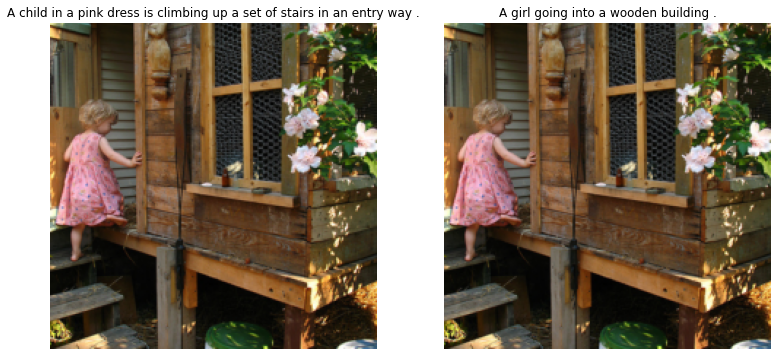

In [13]:
fig = plt.figure(figsize=(20, 6))
for i in range(2):
    sample_item = sample_db.__getitem__(i)
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(sample_item['image'])
    ax.axis('off')
    ax.set_title(sample_item['caption'], wrap=True)

### Dataloaders

We make standard 80-20% train/test splits.

In [14]:
def make_train_valid_dfs(data_dir, val_percent=0.2):
    dataframe = pd.read_csv("%s/captions.csv" % data_dir)
    dataframe['id'] = [id_ for id_ in range(dataframe.shape[0] // 5) for _ in range(5)]
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    valid_ids = np.random.choice(image_ids, size=int(val_percent * len(image_ids)), replace=False)
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

def build_loaders(args, data_frame, mode):
    transforms = get_transforms(args.img_size)
    dataset = TinyFlicker(
        root=args.data_dir,
        data_frame=data_frame,
        tokeniser=text_tokeniser,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

## 2. Network

The *CLIP Network* consists of three main parts:
* **Image encoder** that encodes the visual signal. In theory, it can be any architecture (pretrained network). The only requirement is to have the output as a flattened vector.
* **Text encoder** that encodes the text data. Similar to the image encoder, the text encoder can be any architecture.
* **CLIPNet** projects the image/text embeddings into a common embedding space and computes their similarity
using matrix multiplication.

### Vision

We have hard-coded our `ImageEncoder` to the last layer of a `ResNet50` pretrained on ImageNet.
In our case, the output of `ImageEncoder` is a vector of size 2048.

Interested readers can change the code to support different image encoders.



In [15]:
class ImageEncoder(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        # TODO: use model_name to load other models and set embedding_dim accordingly
        pretrained = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
        self.model = nn.Sequential(*list(pretrained.children())[:-1])
        self.embedding_dim = 2048

    def forward(self, x):
        x = self.model(x)
        return torch.flatten(x, start_dim=1)

### Language

We have hard-coded our `TextEncoder` to the last layer of a `DistilBertModel` which is a 
transformer-based model for natural language processing (NLP) tasks. We use its implementation
from the `transformers` package. We use the `transformers` package instead of `torchtext` because 
it does not have many powerful pretrained text models. 
In our case, the output of `TextEncoder` is a vector of size 768.

Interested readers can change the code to support different text encoders.

In [16]:
class TextEncoder(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        # TODO: use model_name to load other models and set embedding_dim accordingly
        self.model = DistilBertModel.from_pretrained(model_name)
        self.embedding_dim = 768

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

### CLIP Network

The `ProjectionHead` brings the image/text embedding vectors from their corresponding dimensions
(in our case 2048 and 768 respectively) to a common projection space (in our case 256).

The `CLIPNet` combines all the above-mentioned building blocks into one network:
1. Encoding text.
2. Encoding image.
3. Projecting text features into the common space.
4. Projecting image features into the common space.
5. Computing the similarity by doing matrix multiplication (**@** operation) between the projected image/text embeddings.

In [17]:
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [18]:
class CLIPNet(nn.Module):
    def __init__(self, model_vision, model_text, projection_dim):
        super().__init__()
        self.image_encoder = ImageEncoder(model_vision)
        self.text_encoder = TextEncoder(model_text)
        self.image_projection = ProjectionHead(self.image_encoder.embedding_dim, projection_dim)
        self.text_projection = ProjectionHead(self.text_encoder.embedding_dim, projection_dim)

    def forward(self, batch):
        # Getting Image and Text Features
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        image_features = self.image_encoder(batch["image"])
        # Getting Image and Text Embeddings (with the same dimension)
        text_embeddings = self.text_projection(text_features)
        image_embeddings = self.image_projection(image_features)

        # Calculating the Loss
        logits = text_embeddings @ image_embeddings.T
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = torch.softmax((images_similarity + texts_similarity) / 2, dim=-1)
        texts_loss = nn.functional.cross_entropy(logits, targets, reduction='none')
        images_loss = nn.functional.cross_entropy(logits.T, targets.T, reduction='none')
        loss = (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()

In the best theoretical scenario, `text_embeddings` and `image_embedding` matrices should be the same
(or highly correlated) because they are describing similar things. If this happens, what would the 
`logits` matrix look like? Let's see with a simple example!

The `target` (matched image-text pairs) becomes a **diagonal matrix**.

In [19]:
batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
target = torch.softmax(out, dim=-1)
print(target)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


## 3. Train/test routines

The following routines are very similar (close to identical) to what we previously saw in the image classification problem.

In [20]:
def epoch_loop(model, dataloader, optimiser, log_frequency=100):
    # usually the code for train/test has a large overlap.
    is_train = False if optimiser is None else True

    # model should be in train/eval model accordingly
    model.train() if is_train else model.eval()
    
    losses = []
    with torch.set_grad_enabled(is_train):
        for batch_ind, batch in enumerate(dataloader):
            batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
            loss = model(batch)
            losses.extend([loss.item() for _ in range(batch["image"].size(0))])

            if batch_ind % log_frequency == 0 and batch_ind > 0:
                print(
                    '%s batches [%.5d/%.5d] \tloss=%.4f' % (
                        'training' if is_train else 'testing', batch_ind,
                        len(dataloader), np.mean(losses)
                    )
                )

            if is_train:
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
    return losses

In [21]:
def main(args):
    args.data_dir = download_and_extract_db(args.data_dir)
    train_df, valid_df = make_train_valid_dfs(args.data_dir)
    train_loader = build_loaders(args, train_df, mode="train")
    valid_loader = build_loaders(args, valid_df, mode="valid")

    model = CLIPNet(args.model_vision, args.model_text, args.projection_dim)
    model = model.to(device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": args.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": args.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": args.head_lr, "weight_decay": args.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)

    logs = {'train': [], 'val': []}
    for epoch in range(args.epochs):
        print("Epoch: [%.3d/%.3d]" % (epoch, args.epochs))
        model.train()
        train_loss = epoch_loop(model, train_loader, optimizer)
        logs['train'].append(np.mean(train_loss))
        valid_loss = epoch_loop(model, valid_loader, None)
        logs['val'].append(np.mean(valid_loss))

        print('Train     loss=%.4f     Test     loss=%.4f' % 
              (np.mean(train_loss), np.mean(valid_loss)))
        # saving the checkpoint
        torch.save(model.state_dict(), "%s/checkpoint.pth.tar" % args.out_dir)
    return logs

Let's train our network for ten epochs:

In [22]:
args = set_args("--epochs", "10", "--data_dir", "./data/")
print(args)
logs = main(args)

Namespace(epochs=10, batch_size=8, num_workers=0, head_lr=0.001, image_encoder_lr=0.0001, text_encoder_lr=1e-05, weight_decay=0.001, projection_dim=256, model_vision='resnet50', model_text='distilbert-base-uncased', img_size=224, sample_interval=500, out_dir='./out/clip_out/', data_dir='./data/')
Using downloaded and verified file: ./data/TinyFlicker.tar.gz


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [000/010]
training batches [00100/00500] 	loss=5.1429
training batches [00200/00500] 	loss=3.6439
training batches [00300/00500] 	loss=3.1291
training batches [00400/00500] 	loss=2.8670
testing batches [00100/00125] 	loss=1.9155
Train     loss=2.6793     Test     loss=1.9206
Epoch: [001/010]
training batches [00100/00500] 	loss=1.5628
training batches [00200/00500] 	loss=1.3515
training batches [00300/00500] 	loss=1.2118
training batches [00400/00500] 	loss=1.0802
testing batches [00100/00125] 	loss=1.7797
Train     loss=0.9916     Test     loss=1.7860
Epoch: [002/010]
training batches [00100/00500] 	loss=0.4530
training batches [00200/00500] 	loss=0.4435
training batches [00300/00500] 	loss=0.4238
training batches [00400/00500] 	loss=0.4073
testing batches [00100/00125] 	loss=1.7467
Train     loss=0.4025     Test     loss=1.7372
Epoch: [003/010]
training batches [00100/00500] 	loss=0.2419
training batches [00200/00500] 	loss=0.2751
training batches [00300/00500] 	loss=0.2623
tr

### Training progress
Let's plot the evolution of loss for both train and test sets.

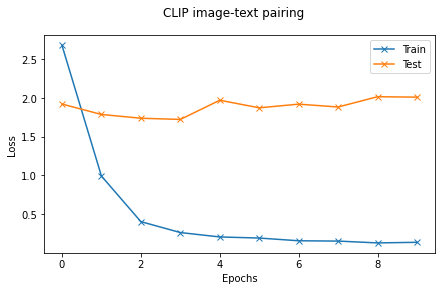

In [23]:
fig = plt.figure(figsize=(7, 4))
fig.suptitle('CLIP image-text pairing')
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.array(logs['train']), '-x', label="Train")
ax.plot(np.array(logs['val']), '-x', label="Test")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

### Prediction

Now we have a model that matches any pairs of image-texts. We can use it for zero-short evaluation
in several applications. In this tutorial, we use it for query matching.

#### Query matching

The `get_image_embeddings` function:
* Loads the model we have trained
* Computed the `image_embeddings` for all images in the validation set and stored it in a list.
* We use the list of `image_embeddings` later on for query matching.

In [24]:
def get_image_embeddings(valid_df, model_path):
    valid_loader = build_loaders(args, valid_df, mode="valid")

    model = CLIPNet(args.model_vision, args.model_text, args.projection_dim).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in valid_loader:
            image_features = model.image_encoder(batch["image"].to(device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [25]:
_, valid_df = make_train_valid_dfs(args.data_dir)
model, image_embeddings = get_image_embeddings(valid_df, "%s/checkpoint.pth.tar" % args.out_dir)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The `find_matches` function searches in all `image_embeddings` and find those
that best match the passed `query` argument.

In [26]:
def find_matches(model, image_embeddings, query, image_filenames, n=3):
    encoded_query = text_tokeniser([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = nn.functional.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = nn.functional.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    transforms = get_transforms(args.img_size, for_network=False)
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    for match, ax in zip(matches, axes.flatten()):
        image = pil_image.open("%s/imgs/%s" % (args.data_dir, match))
        image = transforms(image)
        ax.imshow(image)
        ax.axis("off")
    fig.suptitle('Query: %s' % query)

Let's try our network with three similar phrases to evaluate how well it can distinguish
sutle differences:
* "A man on the mountains."
* "A man next to another human."
* "A man on the road."

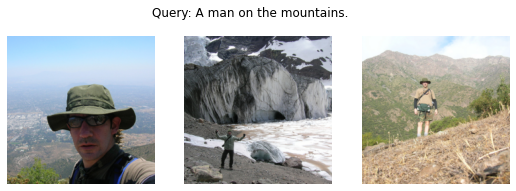

In [27]:
find_matches(
    model, image_embeddings, image_filenames=valid_df['image'].values,
    query="A man on the mountains."
)

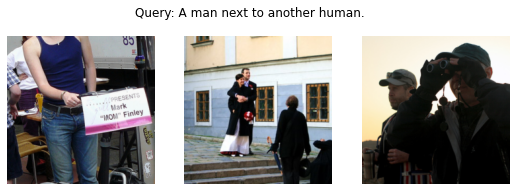

In [28]:
find_matches(
    model, image_embeddings, image_filenames=valid_df['image'].values,
    query="A man next to another human."
)

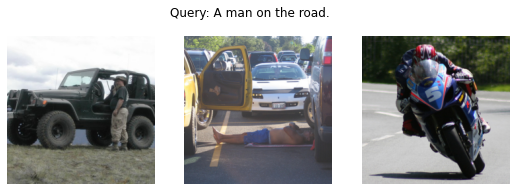

In [29]:
find_matches(
    model, image_embeddings, image_filenames=valid_df['image'].values,
    query="A man on the road."
)

## Excercises
Below is a list of exercises to practice what we have learnt in this notebook:
1. Change the vision encoder from ResNet to another network, e.g. ViT.
2. Plot the query matching results before any training and after each epoch. How fast do the results become qualitatively acceptable?
3. Train the network without using the pretrained weights.
4. Add data augmentation to the training pipeline (both for images and captions).

## References
The following sources inspire the materials in this notebook:
1. [OpenAI CLIP](https://github.com/openai/CLIP)
2. [Simple CLIP in PyTorch](https://github.com/moein-shariatnia/OpenAI-CLIP)